In [873]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, nsolve
from sympy import cosh, sin , sinh, cos,exp
from scipy.optimize import fsolve
from scipy.integrate import quad

# System constants
e2, $\hbar$ ,amu, Q

In [874]:
e2=1.43997 ; hbarc=197.3269718 ; amu=931.4943
z1=81 ; m1=205
z2=2 ; m2=4
Q=3.137
mu=m1*m2/(m1+m2)*amu

# Physical model section
$V_N$: cosh           
$V_C$: piecewise    
$V_{pot}$: $V_N+V_C+(l+\frac{1}{2})^2/r^2$

In [875]:
def wspot(r,v0,a0,r0):
    return -v0*(1+np.cosh(r0/a0))/(np.cosh(r/a0)+np.cosh(r0/a0))

def vc(r,z1,z2,rc):
    return np.where(
        r < rc,
        z1 * z2 * e2 * (3 - r**2 / rc**2) /(2 * rc),
        z1 * z2 * e2 / r
    )
    
def vpot(r,v0,a0,r0,z1,z2,rc,l):
    return wspot(r,v0,a0,r0)+vc(r,z1,z2,rc)+(l+0.5)**2/r**2*hbarc**2/(2*mu)

# Para's values of pot  

In [876]:
v0=162.3 ; a0=0.4 ; r0=7.234 ; rc=r0 ; l=5

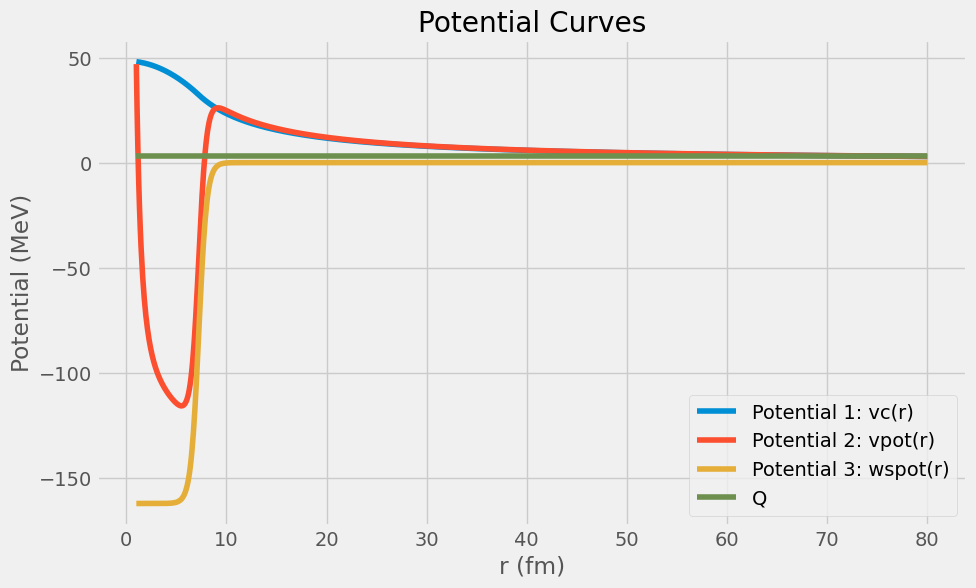

In [877]:
r=np.linspace(1,80,1000)
# 计算每条曲线的 y 值
potential1 = vc(r, z1, z2, rc)
potential2 = vpot(r, v0, a0, r0, z1, z2, rc, l)
potential3 = wspot(r, v0, a0, r0)

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(r, potential1, label='Potential 1: vc(r)')
plt.plot(r, potential2, label='Potential 2: vpot(r)')
plt.plot(r, potential3, label='Potential 3: wspot(r)')
plt.plot(r,[Q]*len(r),label='Q')
# 添加图例和标签
plt.xlabel('r (fm)')
plt.ylabel('Potential (MeV)')
plt.title('Potential Curves')
plt.legend()
plt.show()

# Find classical turning points

In [878]:
guesses = np.linspace(0.1, 80, 100)
roots = []
def f(r):
    return vpot(r, v0, a0, r0, z1, z2, rc, l)-Q
for guess in guesses:
    root = fsolve(f, guess)[0]
    # no duplicate roots
    if root > 0 and not any(np.isclose(root, r, atol=1e-5) for r in roots):
        roots.append(root)
roots.sort()        # sort from small roots to large roots
print("Roots:", roots)

Roots: [1.171147720491274, 7.840127631591141, 75.04699165938146]


$F\int_{r_1}^{r_2}dr \frac{1}{k(r)}cos^2[\int_{r_1}^rdr'k(r')-\frac{\pi}{4}]=1$  
F=$1/\int_{r_1}^{r_2}dr \frac{1}{k(r)}cos^2[\int_{r_1}^rdr'k(r')-\frac{\pi}{4}]$

P,F values

In [879]:
#内部积分函数
def inner_integral(r):
    result, _ = quad(k, roots[0], r)
    return result
#被积函数
def integrand(r):
    inner_int = inner_integral(r)
    return (1 / k(r)) * np.cos(inner_int - np.pi / 4)**2

integral_result, _ = quad(integrand, roots[0], roots[1])    
print("Integral result:", integral_result)
F=1/integral_result
print("F:", F)
P=0.03

Integral result: 1.1078125122590181
F: 0.9026798207585054


Def wave number k and $\Gamma=PF\frac{\hbar^2}{4\mu}exp[-2\int_{r_2}^{r_3} k(r)dr]$   
$T_{1/2}=\hbar ln2/\Gamma$

In [880]:
def k(r):
    return np.sqrt(2*mu/hbarc**2*np.abs(Q-vpot(r,v0,a0,r0,z1,z2,rc,l))) 

result,_=quad(k,roots[1],roots[2])
print("result:",result)

gamma=P*F*hbarc**2/(4*mu)*exp(-2*result)
print("gamma:",gamma,"MeV")

T_half=hbarc*np.log(2)/gamma
print("T_half:",T_half,"fm")

T_half=T_half*1e-23/3
print('T_half',T_half,'s')

T_half=T_half/365/24/3600
print('T_half',T_half,'yrs')

result: 54.10516552696859
gamma: 7.29407912529670e-49 MeV
T_half: 1.87517343590701e+50 fm
T_half 6.25057811969002e+26 s
T_half 1.98204531953641e+19 yrs
